In [1]:
import pandas as pd
import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
import problem
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn.base import BaseEstimator
import sklearn.preprocessing as preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from typing import Dict, Any, Tuple

/Users/mahres/Desktop/machine_learning_schizophrenia/predict-schizophrenia-from-gray-matter/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib is building the font cache; this may take a moment.


# Lecture des données

In [2]:
train_participants = pd.read_csv("data/train_participants.csv")

In [3]:
train_rois = pd.read_csv("data/train_rois.csv")
test_rois = pd.read_csv("data/test_rois.csv")
train_rois.shape

(410, 291)

In [4]:
X_train, y_train = problem.get_train_data(path=".", datatype=["rois"])
X_test, y_test = problem.get_test_data(path=".", datatype=["rois"])

assert X_train.shape[1] == 284 

# Catégorisation des variables en 4 zones cérébrales

Dans le cadre de notre analyse de données visant à prédire la schizophrénie à partir des volumes de matière grise, nous avons choisi de catégoriser les variables anatomiques selon quatre grandes structures cérébrales. Ce choix repose sur des considérations à la fois neurobiologiques et analytiques : il permet une lecture plus structurée des résultats et facilite l’interprétation fonctionnelle des anomalies observées. Voici les catégories retenues :

1. **Le cortex cérébral** :
Le cortex cérébral est la couche externe du cerveau, composée de matière grise. Il regroupe les principales fonctions cognitives supérieures telles que la perception, la mémoire, le langage, la prise de décision ou encore la motricité volontaire. En le subdivisant en régions spécialisées (frontal, temporal, pariétal, occipital), nous pouvons explorer de manière ciblée les zones fréquemment associées à des dysfonctionnements cognitifs chez les patients schizophrènes.

2. **Les structures sous-corticales** : 
Situées sous le cortex, ces structures incluent notamment les noyaux basaux, le thalamus, l’amygdale et l’hippocampe. Elles jouent un rôle central dans la mémoire, les émotions, la motivation et la régulation des comportements. Leur implication dans les circuits limbiques, souvent perturbés en cas de schizophrénie, justifie leur regroupement en tant que catégorie distincte d’analyse.

3. **Le tronc cérébral** :
Le tronc cérébral assure la connexion entre le cerveau et la moelle épinière, et régule des fonctions vitales telles que la respiration, le rythme cardiaque ou le sommeil. Bien que moins souvent étudié dans la littérature sur la schizophrénie, son rôle dans la modulation de l’éveil et des signaux sensoriels en fait une région potentiellement pertinente, surtout dans les formes sévères de la maladie.

4. **Le cervelet** : 
Longtemps considéré comme une structure purement motrice, le cervelet est aujourd’hui reconnu pour son implication dans des fonctions cognitives, émotionnelles et attentionnelles. Son implication croissante dans les troubles psychiatriques, et notamment dans les troubles de la coordination motrice et cognitive chez les patients schizophrènes, justifie son traitement séparé dans notre catégorisation.

In [5]:
cortex_cerebral_GM = ["lAntIns_GM_Vol", "rAntIns_GM_Vol" ,
                "lAntOrbGy_GM_Vol", "rAntOrbGy_GM_Vol" ,
                "lFroOpe_GM_Vol", "rFroOpe_GM_Vol" ,
                "lFroPo_GM_Vol", "rFroPo_GM_Vol" ,
                "lMidFroGy_GM_Vol", "rMidFroGy_GM_Vol" ,
                "lMedFroCbr_GM_Vol", "rMedFroCbr_GM_Vol" ,
                "lSupMedFroGy_GM_Vol", "rSupMedFroGy_GM_Vol" ,
                "lInfFroGy_GM_Vol", "rInfFroGy_GM_Vol" ,
                "lInfFroOrbGy_GM_Vol", "rInfFroOrbGy_GM_Vol" ,
                "lSupFroGy_GM_Vol", "rSupFroGy_GM_Vol" ,
                "lInfFroAngGy_GM_Vol", "rInfFroAngGy_GM_Vol", 
                "lAngGy_GM_Vol", "rAngGy_GM_Vol",
                "lCun_GM_Vol", "rCun_GM_Vol" ,
                "lInfOccGy_GM_Vol", "rInfOccGy_GM_Vol" ,
                "lMidOccGy_GM_Vol", "rMidOccGy_GM_Vol" ,
                "lOccPo_GM_Vol", "rOccPo_GM_Vol" ,
                "lPCu_GM_Vol", "rPCu_GM_Vol" ,
                "lParHipGy_GM_Vol", "rParHipGy_GM_Vol" ,
                "lParOpe_GM_Vol", "rParOpe_GM_Vol" ,
                "lPoCGy_GM_Vol", "rPoCGy_GM_Vol" ,
                "lSupParLo_GM_Vol", "rSupParLo_GM_Vol" ,
                "lOccFusGy_GM_Vol", "rOccFusGy_GM_Vol" ,
                "lPosOrbGy_GM_Vol", "rPosOrbGy_GM_Vol",
                "lSupOccGy_GM_Vol", "rSupOccGy_GM_Vol", 
                "lEnt_GM_Vol", "rEnt_GM_Vol" ,
                "lFusGy_GM_Vol", "rFusGy_GM_Vol" ,
                "lInfTemGy_GM_Vol", "rInfTemGy_GM_Vol" ,
                "lMidTemGy_GM_Vol", "rMidTemGy_GM_Vol" ,
                "lTem_GM_Vol", "rTem_GM_Vol" ,
                "lTemPo_GM_Vol", "rTemPo_GM_Vol" ,
                "lTemTraGy_GM_Vol", "rTemTraGy_GM_Vol" ,
                "lPosIns_GM_Vol", "rPosIns_GM_Vol",
                "lPosCinGy_GM_Vol", "rPosCinGy_GM_Vol" ,
                "lCenOpe_GM_Vol", "rCenOpe_GM_Vol",
                "lCal+Cbr_GM_Vol", "rCal+Cbr_GM_Vol",
                "lRecGy_GM_Vol", "rRecGy_GM_Vol" ,
                "lLinGy_GM_Vol", "rLinGy_GM_Vol" ,
                "lLatOrbGy_GM_Vol", "rLatOrbGy_GM_Vol" ,
                "lMidCinGy_GM_Vol", "rMidCinGy_GM_Vol" ,
                "lMedOrbGy_GM_Vol", "rMedOrbGy_GM_Vol" ,
                "lMedPoCGy_GM_Vol", "rMedPoCGy_GM_Vol" ,
                "lMedPrcGy_GM_Vol", "rMedPrcGy_GM_Vol" ,
                "lPrcGy_GM_Vol", "rPrcGy_GM_Vol" ,
                "lPla_GM_Vol", "rPla_GM_Vol" ,
                "lSCA_GM_Vol", "rSCA_GM_Vol" ,
                "lSupMarGy_GM_Vol", "rSupMarGy_GM_Vol", 
                "lAntCinGy_GM_Vol", "rAntCinGy_GM_Vol", 
                "lOC_GM_Vol", "rOC_GM_Vol"]

cortex_cerebral_CSF = ["lCenOpe_CSF_Vol", "rCenOpe_CSF_Vol" ,
                "lFroOpe_CSF_Vol", "rFroOpe_CSF_Vol" ,
                "lFroPo_CSF_Vol", "rFroPo_CSF_Vol",
                "lMidFroGy_CSF_Vol", "rMidFroGy_CSF_Vol" ,
                "lMedFroCbr_CSF_Vol", "rMedFroCbr_CSF_Vol" ,
                "lSupMedFroGy_CSF_Vol", "rSupMedFroGy_CSF_Vol" ,
                "lLatOrbGy_CSF_Vol", "rLatOrbGy_CSF_Vol" ,
                "lMedOrbGy_CSF_Vol", "rMedOrbGy_CSF_Vol" ,
                "lInfFroGy_CSF_Vol", "rInfFroGy_CSF_Vol" ,
                "lInfFroOrbGy_CSF_Vol", "rInfFroOrbGy_CSF_Vol" ,
                "lPosIns_CSF_Vol", "rPosIns_CSF_Vol" ,
                "lSupFroGy_CSF_Vol", "rSupFroGy_CSF_Vol" ,
                "lInfFroAngGy_CSF_Vol", "rInfFroAngGy_CSF_Vol" ,
                "lPrcGy_CSF_Vol", "rPrcGy_CSF_Vol", 
                "lInfOccGy_CSF_Vol", "rInfOccGy_CSF_Vol" ,
                "lMidOccGy_CSF_Vol", "rMidOccGy_CSF_Vol" ,
                "lOccPo_CSF_Vol", "rOccPo_CSF_Vol" ,
                "lOccFusGy_CSF_Vol", "rOccFusGy_CSF_Vol" ,
                "lCun_CSF_Vol", "rCun_CSF_Vol" ,
                "lPosCinGy_CSF_Vol", "rPosCinGy_CSF_Vol" ,
                "lPCu_CSF_Vol", "rPCu_CSF_Vol" ,
                "lPoCGy_CSF_Vol", "rPoCGy_CSF_Vol" ,
                "lParOpe_CSF_Vol", "rParOpe_CSF_Vol" ,
                "lSupParLo_CSF_Vol", "rSupParLo_CSF_Vol" ,
                "lSupOccGy_CSF_Vol", "rSupOccGy_CSF_Vol" ,
                "lPosOrbGy_CSF_Vol", "rPosOrbGy_CSF_Vol" ,
                "lInfTemGy_CSF_Vol", "rInfTemGy_CSF_Vol" ,
                "lMidTemGy_CSF_Vol", "rMidTemGy_CSF_Vol" ,
                "lEnt_CSF_Vol", "rEnt_CSF_Vol" ,
                "lParHipGy_CSF_Vol", "rParHipGy_CSF_Vol" ,
                "lTem_CSF_Vol", "rTem_CSF_Vol" ,
                "lSupTemGy_CSF_Vol", "rSupTemGy_CSF_Vol" ,
                "lTemPo_CSF_Vol", "rTemPo_CSF_Vol" ,
                "lTemTraGy_CSF_Vol", "rTemTraGy_CSF_Vol" ,
                "lOC_CSF_Vol", "rOC_CSF_Vol" ,
                "lAntCinGy_CSF_Vol", "rAntCinGy_CSF_Vol" ,
                "lAntIns_CSF_Vol", "rAntIns_CSF_Vol" ,
                "lAntOrbGy_CSF_Vol", "rAntOrbGy_CSF_Vol" ,
                "lAngGy_CSF_Vol", "rAngGy_CSF_Vol" ,
                "lCal+Cbr_CSF_Vol", "rCal+Cbr_CSF_Vol"]

structures_sous_corticales_GM = ["lAcc_GM_Vol", "rAcc_GM_Vol" ,
                "lAmy_GM_Vol", "rAmy_GM_Vol" ,
                "lBst_GM_Vol", "rBst_GM_Vol" ,
                "lCau_GM_Vol", "rCau_GM_Vol" ,
                "lPal_GM_Vol", "rPal_GM_Vol" ,
                "lPut_GM_Vol", "rPut_GM_Vol" ,
                "lThaPro_GM_Vol", "rThaPro_GM_Vol", 
                "lBasCbr+FobBr_GM_Vol", "rBasCbr+FobBr_GM_Vol"]

structures_sous_corticales_CSF = ["lAcc_CSF_Vol", "rAcc_CSF_Vol" ,
                "lAmy_CSF_Vol", "rAmy_CSF_Vol" ,
                "lBst_CSF_Vol", "rBst_CSF_Vol" ,
                "lCau_CSF_Vol", "rCau_CSF_Vol" ,
                "lPal_CSF_Vol", "rPal_CSF_Vol" ,
                "lPut_CSF_Vol", "rPut_CSF_Vol" ,
                "lThaPro_CSF_Vol", "rThaPro_CSF_Vol" ,
                "lLinGy_CSF_Vol", "rLinGy_CSF_Vol" ,
                "lMidCinGy_CSF_Vol", "rMidCinGy_CSF_Vol" ,
                "lMedPoCGy_CSF_Vol", "rMedPoCGy_CSF_Vol" ,
                "lMedPrcGy_CSF_Vol", "rMedPrcGy_CSF_Vol" ,
                "lFusGy_CSF_Vol", "rFusGy_CSF_Vol" ,
                "lRecGy_CSF_Vol", "rRecGy_CSF_Vol", 
                "lBasCbr+FobBr_CSF_Vol", "rBasCbr+FobBr_CSF_Vol", 
                "lPla_CSF_Vol", "rPla_CSF_Vol", 
                "lSCA_CSF_Vol", "rSCA_CSF_Vol", 
                "lCbr+Mot_CSF_Vol", "rCbr+Mot_CSF_Vol", 
                "lSupMarGy_CSF_Vol", "rSupMarGy_CSF_Vol"]

tronc_cerebral_GM = ["l3thVen_GM_Vol", "r3thVen_GM_Vol" ,
                "l4thVen_GM_Vol", "r4thVen_GM_Vol" ,
                "lInfLatVen_GM_Vol", "rInfLatVen_GM_Vol" ,
                "lLatVen_GM_Vol", "rLatVen_GM_Vol" ,
                "lVenVen_GM_Vol", "rVenVen_GM_Vol"]
                
tronc_cerebral_CSF = ["l3thVen_CSF_Vol", "r3thVen_CSF_Vol" ,
                "l4thVen_CSF_Vol", "r4thVen_CSF_Vol" ,
                "lCSF_CSF_Vol", "rCSF_CSF_Vol" ,
                "lInfLatVen_CSF_Vol", "rInfLatVen_CSF_Vol" ,
                "lLatVen_CSF_Vol", "rLatVen_CSF_Vol" ,
                "lVenVen_CSF_Vol", "rVenVen_CSF_Vol"]

cervelet_GM = ["lExtCbe_GM_Vol", "rExtCbe_GM_Vol" ,
                "lCbeWM_GM_Vol", "rCbeWM_GM_Vol" ,
                "lCbeLoCbe1-5_GM_Vol", "rCbeLoCbe1-5_GM_Vol" ,
                "lCbeLoCbe6-7_GM_Vol", "rCbeLoCbe6-7_GM_Vol" ,
                "lCbeLoCbe8-10_GM_Vol", "rCbeLoCbe8-10_GM_Vol"]

cervelet_CSF = ["lExtCbe_CSF_Vol", "rExtCbe_CSF_Vol", 
                "lCbeLoCbe1-5_CSF_Vol", "rCbeLoCbe1-5_CSF_Vol",
                "lCbeLoCbe6-7_CSF_Vol", "rCbeLoCbe6-7_CSF_Vol",
                "lCbeLoCbe8-10_CSF_Vol", "rCbeLoCbe8-10_CSF_Vol"]
                
autre_GM = ["lCbr+Mot_GM_Vol", 
               "rCbr+Mot_GM_Vol","lCbrWM_GM_Vol",
               "rCbrWM_GM_Vol",
               "lCSF_GM_Vol",
               "rCSF_GM_Vol",
               "lHip_GM_Vol",
               "rHip_GM_Vol",
               "lSupTemGy_GM_Vol",
               "rSupTemGy_GM_Vol"]

autre_CSF = ["lCbeWM_CSF_Vol", "rCbeWM_CSF_Vol" ,
               "lCbrWM_CSF_Vol", "rCbrWM_CSF_Vol", "lHip_CSF_Vol",
               "rHip_CSF_Vol"]


In [6]:
assert len(cortex_cerebral_GM) + len(cortex_cerebral_CSF) + len(structures_sous_corticales_GM) + len(structures_sous_corticales_CSF) + len(tronc_cerebral_GM) + len(tronc_cerebral_CSF) + len(cervelet_GM) + len(cervelet_CSF) + len(autre_GM) + len(autre_CSF) == train_rois.shape[1] - 7

# Calcul du volume total pour les 5 nouvelles variables créées

In [7]:
zones = [
    (cortex_cerebral_GM, cortex_cerebral_CSF, "cortex_cerebral"),
    (structures_sous_corticales_GM, structures_sous_corticales_CSF, "structures_sous_corticales"),
    (tronc_cerebral_GM, tronc_cerebral_CSF, "tronc_cerebral"),
    (cervelet_GM, cervelet_CSF, "cervelet"),
    (autre_GM, autre_CSF, "autre")
]

for zone_GM, zone_CSF, zone in zones:
    train_rois[f"Vol_GM_{zone}"] = train_rois[zone_GM].sum(axis=1)
    train_rois[f"Vol_CSF_{zone}"] = train_rois[zone_CSF].sum(axis=1)

for zone_GM, zone_CSF, zone in zones:
    test_rois[f"Vol_GM_{zone}"] = test_rois[zone_GM].sum(axis=1)
    test_rois[f"Vol_CSF_{zone}"] = test_rois[zone_CSF].sum(axis=1)


# Test de normalité 

Dans le cadre de notre projet de prédiction de la schizophrénie à partir des volumes de matière grise, un test de normalité a été réalisé afin de vérifier la distribution des données pour chaque région cérébrale. Cette étape est essentielle pour déterminer si les variables suivent une loi normale, ce qui conditionne le choix des méthodes statistiques et des modèles d’analyse appropriés. Elle permet également d’identifier d’éventuelles asymétries ou valeurs extrêmes, pouvant être révélatrices de différences significatives entre les groupes sains et atteints, et donc pertinentes pour la modélisation.

In [8]:
from scipy.stats import shapiro

# Filtrer pour ne garder que les colonnes numériques
numerical_columns = train_rois.select_dtypes(include=['number']).columns

# Effectuer le test de Shapiro-Wilk pour chaque colonne numérique
for col in numerical_columns:
    stat, p_value = shapiro(train_rois[col])
    print(f"Shapiro-Wilk Test for {col}: Statistics={stat:.4f}, p-value={p_value:.4f}")
    
    if p_value > 0.05:
        print(f"{col} semble suivre une distribution normale (p-value > 0.05)\n")
    else:
        print(f"{col} ne semble pas suivre une distribution normale (p-value <= 0.05)\n")


Shapiro-Wilk Test for run: Statistics=1.0000, p-value=1.0000
run semble suivre une distribution normale (p-value > 0.05)

Shapiro-Wilk Test for TIV: Statistics=0.9959, p-value=0.3647
TIV semble suivre une distribution normale (p-value > 0.05)

Shapiro-Wilk Test for CSF_Vol: Statistics=0.9615, p-value=0.0000
CSF_Vol ne semble pas suivre une distribution normale (p-value <= 0.05)

Shapiro-Wilk Test for GM_Vol: Statistics=0.9940, p-value=0.1093
GM_Vol semble suivre une distribution normale (p-value > 0.05)

Shapiro-Wilk Test for WM_Vol: Statistics=0.9930, p-value=0.0542
WM_Vol semble suivre une distribution normale (p-value > 0.05)

Shapiro-Wilk Test for l3thVen_GM_Vol: Statistics=0.9477, p-value=0.0000
l3thVen_GM_Vol ne semble pas suivre une distribution normale (p-value <= 0.05)

Shapiro-Wilk Test for r3thVen_GM_Vol: Statistics=0.9721, p-value=0.0000
r3thVen_GM_Vol ne semble pas suivre une distribution normale (p-value <= 0.05)

Shapiro-Wilk Test for l4thVen_GM_Vol: Statistics=0.9480, p

/Users/mahres/Desktop/machine_learning_schizophrenia/predict-schizophrenia-from-gray-matter/venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


# Normalisation des données

In [9]:
train_rois = train_rois.drop(train_rois.columns[:4], axis=1)
test_rois = test_rois.drop(test_rois.columns[:4], axis=1)

In [10]:
scaler = MinMaxScaler()
train_rois_scaled = scaler.fit_transform(train_rois)
test_rois_scaled = scaler.transform(test_rois)

# Encodage de la cible

In [11]:
# Remplacez les valeurs directement
y_train = np.where(y_train == 'schizophrenia', 1, 0)
y_test = np.where(y_test == 'schizophrenia', 1, 0)

# Modélisation

In [12]:
class ModelOptimizer:
    def __init__(self, X_train, X_test, y_train, y_test, random_state=42):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.random_state = random_state
        
        self.param_spaces = {
            'l1_logreg': {  
                'C': ('float', 1e-6, 0.1, True),  
                'penalty': ['l1'],
                'solver': ['liblinear'],
                'max_iter': ('int', 1000, 5000)
            },
            'l2_logreg': {  
                'C': ('float', 1e-6, 0.1, True),  
                'penalty': ['l2'],
                'solver': ['lbfgs'],
                'max_iter': ('int', 1000, 5000)
            },
            'EN_logreg': {
                'C': ('float', 1e-6, 0.1, True),  
                'solver': ['saga'],
                'max_iter': ('int', 1000, 5000),
                'penalty': ['elasticnet'],
                'l1_ratio': ('float', 0.3, 0.7)
            },
            'svc': {
                'C': ('float', 1e-6, 0.1, True),  
                'kernel': ['rbf'],
                'gamma': ('float', 1e-6, 1e-3, True)  
            },
            'knn': {
                'n_neighbors': ('int', 10, 20),  
                'weights': ['uniform'],
                'p': ('int', 2, 2),
                'leaf_size': ('int', 30, 40)  
            },
            'gbc': {
                'n_estimators': ('int', 50, 100),
                'learning_rate': ('float', 1e-5, 1e-3, True),  
                'max_depth': ('int', 2, 5),  
                'subsample': ('float', 0.5, 0.8),  
                'min_samples_split': ('int', 10, 20),  
                'min_samples_leaf': ('int', 5, 10),  
                'max_features': ('float', 0.3, 0.5)  
            },
            'rf': {  
                'n_estimators': ('int', 50, 100),  
                'max_depth': ('int', 5, 20),  
                'min_samples_split': ('int', 5, 10),  
                'min_samples_leaf': ('int', 2, 5),  
                'max_features': ['sqrt', 'log2'],
                'bootstrap': [True, False]
            }
        }

    def _suggest_parameters(self, trial: optuna.Trial, model_name: str) -> Dict[str, Any]:
        
        params = {}
        space = self.param_spaces[model_name]
        
        for param_name, param_config in space.items():
            if isinstance(param_config, list):
                params[param_name] = trial.suggest_categorical(param_name, param_config)
            else:
                param_type, low, high, *log = param_config
                if param_type == 'int':
                    params[param_name] = trial.suggest_int(param_name, low, high)
                elif param_type == 'float':
                    params[param_name] = trial.suggest_float(
                        param_name, low, high, 
                        log=log[0] if log else False
                    )
        
        return params

    def _get_model(self, model_name: str, params: Dict[str, Any]) -> Any:
        
        if model_name in ['l1_logreg', 'l2_logreg', 'EN_logreg']:
           
            if 'penalty' in params:
                penalty = params.pop('penalty')
            l1_ratio = params.pop('l1_ratio', None)
            
            if model_name == 'l1_logreg':
                return LogisticRegression(
                    penalty='l1',
                    **params,
                    random_state=self.random_state
                )
            elif model_name == 'l2_logreg':
                return LogisticRegression(
                    penalty='l2',
                    **params,
                    random_state=self.random_state
                )
            else:
                return LogisticRegression(
                    penalty='elasticnet',
                    l1_ratio=l1_ratio,
                    **params,
                    random_state=self.random_state
                )
        
        models = {
            'svc': lambda **params: SVC(**params, probability=True, random_state=self.random_state),
            'knn': KNeighborsClassifier,
            'gbc': lambda **params: GradientBoostingClassifier(**params, random_state=self.random_state),
            'rf': lambda **params: RandomForestClassifier(**params, random_state=self.random_state)
        }
        
        return models[model_name](**params)

    def optimize_model(self, model_name: str, n_trials: int = 50) -> Tuple[Any, Dict[str, Any], float]:
        """Optimise les hyperparamètres avec validation croisée."""
        def objective(trial):
            params = self._suggest_parameters(trial, model_name)
            model = self._get_model(model_name, params)
            
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
            
            scores = cross_val_score(
                model, self.X_train, self.y_train, 
                cv=cv, scoring='roc_auc', n_jobs=-1
            )
            
            return np.mean(scores) - 0.5 * np.std(scores)

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials)
        
        best_params = study.best_trial.params
        best_model = self._get_model(model_name, best_params)
        best_score = study.best_value

        return best_model, best_params, best_score

    def evaluate_model(self, model: Any) -> Tuple[float, float]:
        model.fit(self.X_train, self.y_train)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
        
        train_scores = []
        test_scores = []
        
        for train_idx, val_idx in cv.split(self.X_train, self.y_train):
            X_train_cv, X_val_cv = self.X_train[train_idx], self.X_train[val_idx]
            y_train_cv, y_val_cv = self.y_train[train_idx], self.y_train[val_idx]

            
            model.fit(X_train_cv, y_train_cv)
            
            train_scores.append(roc_auc_score(
                y_train_cv,
                model.predict_proba(X_train_cv)[:, 1]
            ))
            test_scores.append(roc_auc_score(
                y_val_cv,
                model.predict_proba(X_val_cv)[:, 1]
            ))
        
        return np.mean(train_scores), np.mean(test_scores)

def main(X_train, X_test, y_train, y_test):
    optimizer = ModelOptimizer(X_train, X_test, y_train, y_test)
    models = ['l1_logreg', 'l2_logreg', 'EN_logreg', 'svc', 'knn', 'gbc', 'rf']
    results = {}
    comparison_data = []
    
    for model_name in models:
        print(f"\nOptimisation de {model_name}...")

        best_model, best_params, cv_score = optimizer.optimize_model(model_name)
        train_auc, val_auc = optimizer.evaluate_model(best_model)

        best_model.fit(optimizer.X_train, optimizer.y_train)
        test_auc = roc_auc_score(
            optimizer.y_test,
            best_model.predict_proba(optimizer.X_test)[:, 1]
        )

        overfitting_rate = ((train_auc - test_auc) / train_auc) * 100

        print(f"Meilleurs hyperparamètres pour {model_name}: {best_params}")
        print(f"Meilleur score (CV AUC) pour {model_name}: {cv_score:.4f}")

        model_display_names = {
            'l1_logreg': 'Régression Logistique L1 (Lasso)',
            'l2_logreg': 'Régression Logistique L2 (Ridge)',
            'EN_logreg': 'Régression Logistique (Elastic Net)',
            'svc': 'SVM',
            'knn': 'k-NN',
            'gbc': 'Gradient Boosting',
            'rf': 'Random Forest'
        }

        comparison_data.append({
            'Modèle': model_display_names[model_name],
            'Train AUC': train_auc,
            'CV AUC': cv_score,
            'Validation AUC': val_auc,
            'Test AUC': test_auc,
            'Overfitting (%)': overfitting_rate
        })

        results[model_name] = {
            'model': best_model,
            'params': best_params,
            'metrics': {
                'train_auc': train_auc,
                'cv_auc': cv_score,
                'val_auc': val_auc,
                'test_auc': test_auc,
                'overfitting_rate': overfitting_rate
            }
        }

  
    df = pd.DataFrame(comparison_data)
    df = df.set_index('Modèle')


    for col in ['Train AUC', 'CV AUC', 'Validation AUC', 'Test AUC']:
        df[col] = df[col].map('{:.4f}'.format)
    df['Overfitting (%)'] = df['Overfitting (%)'].map('{:.2f}'.format)


    print("\n" + "="*90)
    print(" "*35 + "TABLEAU COMPARATIF DES MODÈLES")
    print("="*90)

 
    table_str = df.to_string()
    lines = table_str.split('\n')
    width = len(lines[0])
    separator = '-' * width

    print(separator)
    print(lines[0])  
    print(separator)
    for line in lines[1:]:
        print(line)
    print(separator)


    best_model_idx = df['Test AUC'].astype(float).idxmax()
    print(f"\nMeilleur modèle: {best_model_idx}")
    print(f"Score CV: {df.loc[best_model_idx, 'CV AUC']}")
    print(f"Score de test: {df.loc[best_model_idx, 'Test AUC']}")
    print(f"Taux d'overfitting: {df.loc[best_model_idx, 'Overfitting (%)']}%")

    return results, df

if __name__ == "__main__":
    results, comparison_df = main(train_rois_scaled, test_rois_scaled, y_train, y_test)


[I 2025-05-25 13:56:47,987] A new study created in memory with name: no-name-439a56ff-9a1f-465c-bded-2a5cc69c8c00



Optimisation de l1_logreg...


[I 2025-05-25 13:56:49,798] Trial 0 finished with value: 0.5 and parameters: {'C': 8.438554351665749e-05, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 1746}. Best is trial 0 with value: 0.5.
[I 2025-05-25 13:56:50,193] Trial 1 finished with value: 0.5 and parameters: {'C': 4.254989648497157e-06, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 1534}. Best is trial 0 with value: 0.5.
[I 2025-05-25 13:56:50,220] Trial 2 finished with value: 0.5 and parameters: {'C': 0.0025525574533461068, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 3676}. Best is trial 0 with value: 0.5.
[I 2025-05-25 13:56:50,233] Trial 3 finished with value: 0.5 and parameters: {'C': 0.0005119161391183639, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 2517}. Best is trial 0 with value: 0.5.
[I 2025-05-25 13:56:50,248] Trial 4 finished with value: 0.5 and parameters: {'C': 3.641851145348246e-06, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 4973}. Best is trial 0 with value: 0.5.
[I 2025-05

Meilleurs hyperparamètres pour l1_logreg: {'C': 0.09982126093117841, 'solver': 'liblinear', 'max_iter': 3264}
Meilleur score (CV AUC) pour l1_logreg: 0.6580

Optimisation de l2_logreg...


[I 2025-05-25 13:56:51,712] Trial 12 finished with value: 0.7707345093744861 and parameters: {'C': 0.09659128261913198, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 3694}. Best is trial 10 with value: 0.7717374554293904.
[I 2025-05-25 13:56:51,730] Trial 13 finished with value: 0.7058375739133731 and parameters: {'C': 0.009708681829775717, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 3721}. Best is trial 10 with value: 0.7717374554293904.
[I 2025-05-25 13:56:51,748] Trial 14 finished with value: 0.7071335781653232 and parameters: {'C': 0.010493173185693736, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 1868}. Best is trial 10 with value: 0.7717374554293904.
[I 2025-05-25 13:56:51,764] Trial 15 finished with value: 0.7108142827941262 and parameters: {'C': 0.011964677289400013, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 3210}. Best is trial 10 with value: 0.7717374554293904.
[I 2025-05-25 13:56:51,780] Trial 16 finished with value: 0.7681669074630124 and parameters: {'C': 0.

Meilleurs hyperparamètres pour l2_logreg: {'C': 0.09862744831831488, 'solver': 'lbfgs', 'max_iter': 3287}
Meilleur score (CV AUC) pour l2_logreg: 0.7719

Optimisation de EN_logreg...


[I 2025-05-25 13:56:52,642] Trial 8 finished with value: 0.6926911021083625 and parameters: {'C': 0.03555184716677087, 'solver': 'saga', 'max_iter': 2759, 'penalty': 'elasticnet', 'l1_ratio': 0.3389185210507538}. Best is trial 0 with value: 0.6965383951132466.
[I 2025-05-25 13:56:52,656] Trial 9 finished with value: 0.5 and parameters: {'C': 1.5800339193171967e-06, 'solver': 'saga', 'max_iter': 2005, 'penalty': 'elasticnet', 'l1_ratio': 0.30098397372578367}. Best is trial 0 with value: 0.6965383951132466.
[I 2025-05-25 13:56:52,735] Trial 10 finished with value: 0.7029730191414225 and parameters: {'C': 0.06653384919847626, 'solver': 'saga', 'max_iter': 3667, 'penalty': 'elasticnet', 'l1_ratio': 0.6823325988448099}. Best is trial 10 with value: 0.7029730191414225.
[I 2025-05-25 13:56:52,766] Trial 11 finished with value: 0.5 and parameters: {'C': 0.04769110587125449, 'solver': 'saga', 'max_iter': 3700, 'penalty': 'elasticnet', 'l1_ratio': 0.6512223971401299}. Best is trial 10 with value

Meilleurs hyperparamètres pour EN_logreg: {'C': 0.09641606342665382, 'solver': 'saga', 'max_iter': 4736}
Meilleur score (CV AUC) pour EN_logreg: 0.7448

Optimisation de svc...


[I 2025-05-25 13:56:55,264] Trial 2 finished with value: 0.6863883391239819 and parameters: {'C': 1.0084918417910787e-05, 'kernel': 'rbf', 'gamma': 4.892936855892611e-06}. Best is trial 0 with value: 0.6867641010505654.
[I 2025-05-25 13:56:55,324] Trial 3 finished with value: 0.6866667511570392 and parameters: {'C': 0.07125572205051518, 'kernel': 'rbf', 'gamma': 3.1463799253552863e-06}. Best is trial 0 with value: 0.6867641010505654.
[I 2025-05-25 13:56:55,382] Trial 4 finished with value: 0.6851023669471366 and parameters: {'C': 0.07362177859005391, 'kernel': 'rbf', 'gamma': 0.00026883388517989456}. Best is trial 0 with value: 0.6867641010505654.
[I 2025-05-25 13:56:55,444] Trial 5 finished with value: 0.6866864124494156 and parameters: {'C': 0.008121924742270421, 'kernel': 'rbf', 'gamma': 3.3836446583319506e-06}. Best is trial 0 with value: 0.6867641010505654.
[I 2025-05-25 13:56:55,516] Trial 6 finished with value: 0.6863673482096738 and parameters: {'C': 0.0150202924537773, 'kernel

Meilleurs hyperparamètres pour svc: {'C': 0.00011990295552449073, 'kernel': 'rbf', 'gamma': 0.0006830753272018569}
Meilleur score (CV AUC) pour svc: 0.6873

Optimisation de knn...


[I 2025-05-25 13:56:58,980] Trial 7 finished with value: 0.7273201983338725 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 2, 'leaf_size': 34}. Best is trial 4 with value: 0.734951542476129.
[I 2025-05-25 13:56:58,995] Trial 8 finished with value: 0.705316811442152 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'p': 2, 'leaf_size': 37}. Best is trial 4 with value: 0.734951542476129.
[I 2025-05-25 13:56:59,010] Trial 9 finished with value: 0.7064823325984294 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 2, 'leaf_size': 35}. Best is trial 4 with value: 0.734951542476129.
[I 2025-05-25 13:56:59,028] Trial 10 finished with value: 0.738048005174349 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'p': 2, 'leaf_size': 30}. Best is trial 10 with value: 0.738048005174349.
[I 2025-05-25 13:56:59,080] Trial 11 finished with value: 0.738048005174349 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'p': 2, 'leaf_size': 30}. Best is tria

Meilleurs hyperparamètres pour knn: {'n_neighbors': 10, 'weights': 'uniform', 'p': 2, 'leaf_size': 30}
Meilleur score (CV AUC) pour knn: 0.7380

Optimisation de gbc...


[I 2025-05-25 13:57:00,224] Trial 0 finished with value: 0.7776196266618297 and parameters: {'n_estimators': 54, 'learning_rate': 1.7280544640580273e-05, 'max_depth': 5, 'subsample': 0.5790518884429464, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 0.43288379741873756}. Best is trial 0 with value: 0.7776196266618297.
[I 2025-05-25 13:57:00,783] Trial 1 finished with value: 0.7619716075652259 and parameters: {'n_estimators': 81, 'learning_rate': 0.00021663099128791513, 'max_depth': 5, 'subsample': 0.6634085003739789, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': 0.44786396284489455}. Best is trial 0 with value: 0.7776196266618297.
[I 2025-05-25 13:57:01,131] Trial 2 finished with value: 0.7553475424381424 and parameters: {'n_estimators': 88, 'learning_rate': 2.4375481054672198e-05, 'max_depth': 3, 'subsample': 0.6875368297826482, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': 0.31098688082371706}. Best is trial 0 with value: 0.7776196

Meilleurs hyperparamètres pour gbc: {'n_estimators': 68, 'learning_rate': 0.00026949934922726373, 'max_depth': 5, 'subsample': 0.6467160465577358, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 0.43139665098851043}
Meilleur score (CV AUC) pour gbc: 0.7784

Optimisation de rf...


[I 2025-05-25 13:57:23,788] Trial 1 finished with value: 0.7666575192111792 and parameters: {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.7666575192111792.
[I 2025-05-25 13:57:23,883] Trial 2 finished with value: 0.7459020950214669 and parameters: {'n_estimators': 71, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.7666575192111792.
[I 2025-05-25 13:57:24,037] Trial 3 finished with value: 0.7686162866329618 and parameters: {'n_estimators': 55, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 3 with value: 0.7686162866329618.
[I 2025-05-25 13:57:24,294] Trial 4 finished with value: 0.7745306109543745 and parameters: {'n_estimators': 90, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_feature

Meilleurs hyperparamètres pour rf: {'n_estimators': 78, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}
Meilleur score (CV AUC) pour rf: 0.7836

                                   TABLEAU COMPARATIF DES MODÈLES
---------------------------------------------------------------------------------------------
                                    Train AUC  CV AUC Validation AUC Test AUC Overfitting (%)
---------------------------------------------------------------------------------------------
Modèle                                                                                       
Régression Logistique L1 (Lasso)       0.7239  0.6580         0.6890   0.7091            2.04
Régression Logistique L2 (Ridge)       0.8645  0.7719         0.8052   0.8110            6.19
Régression Logistique (Elastic Net)    0.8207  0.7448         0.7849   0.7943            3.21
SVM                                    0.7497  0.6873         0.7388   

# Importances des variables par SHAP

Cette partie vise à interpréter les prédictions des modèles de régression logistique en identifiant les variables cérébrales les plus influentes à l’aide de l’analyse SHAP. L’analyse SHAP (SHapley Additive exPlanations) est une méthode d’explicabilité des modèles de machine learning. Elle permet de comprendre comment chaque variable d’entrée (feature) influence la prédiction d’un modèle.
En calculant et visualisant l’importance des régions du cerveau dans la classification (sain vs schizophrène), nous obtenons une compréhension fine de la contribution de chaque variable. Cela permet non seulement d’expliquer les décisions du modèle, mais aussi de renforcer la validité neuroscientifique des résultats en mettant en évidence les zones cérébrales les plus pertinentes dans le diagnostic.

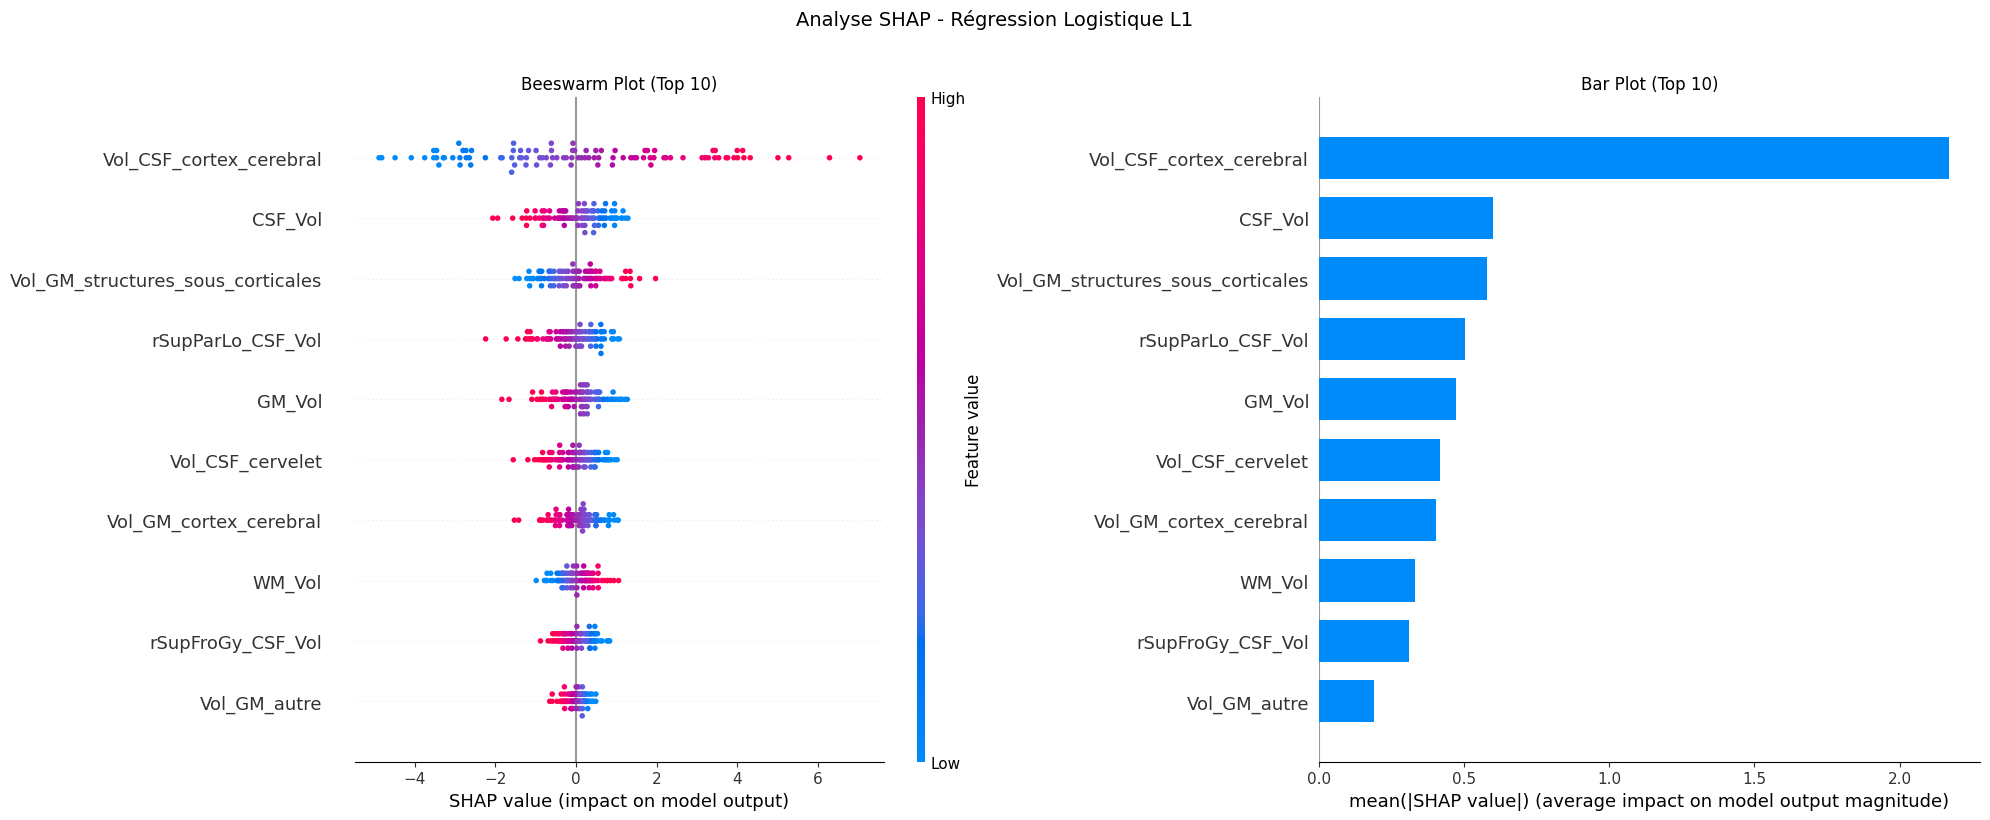


Top 20 variables importantes pour Régression Logistique L1:
[Vol_CSF_cortex_cerebral, CSF_Vol, Vol_GM_structures_sous_corticales, rSupParLo_CSF_Vol, GM_Vol, Vol_CSF_cervelet, Vol_GM_cortex_cerebral, WM_Vol, rSupFroGy_CSF_Vol, Vol_GM_autre, Vol_CSF_structures_sous_corticales, lSupParLo_CSF_Vol, rPut_GM_Vol, Vol_CSF_tronc_cerebral, rAngGy_CSF_Vol, lThaPro_GM_Vol, lSupFroGy_CSF_Vol, rThaPro_GM_Vol, lCal+Cbr_CSF_Vol, lBasCbr+FobBr_CSF_Vol]


/Users/mahres/Desktop/machine_learning_schizophrenia/predict-schizophrenia-from-gray-matter/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


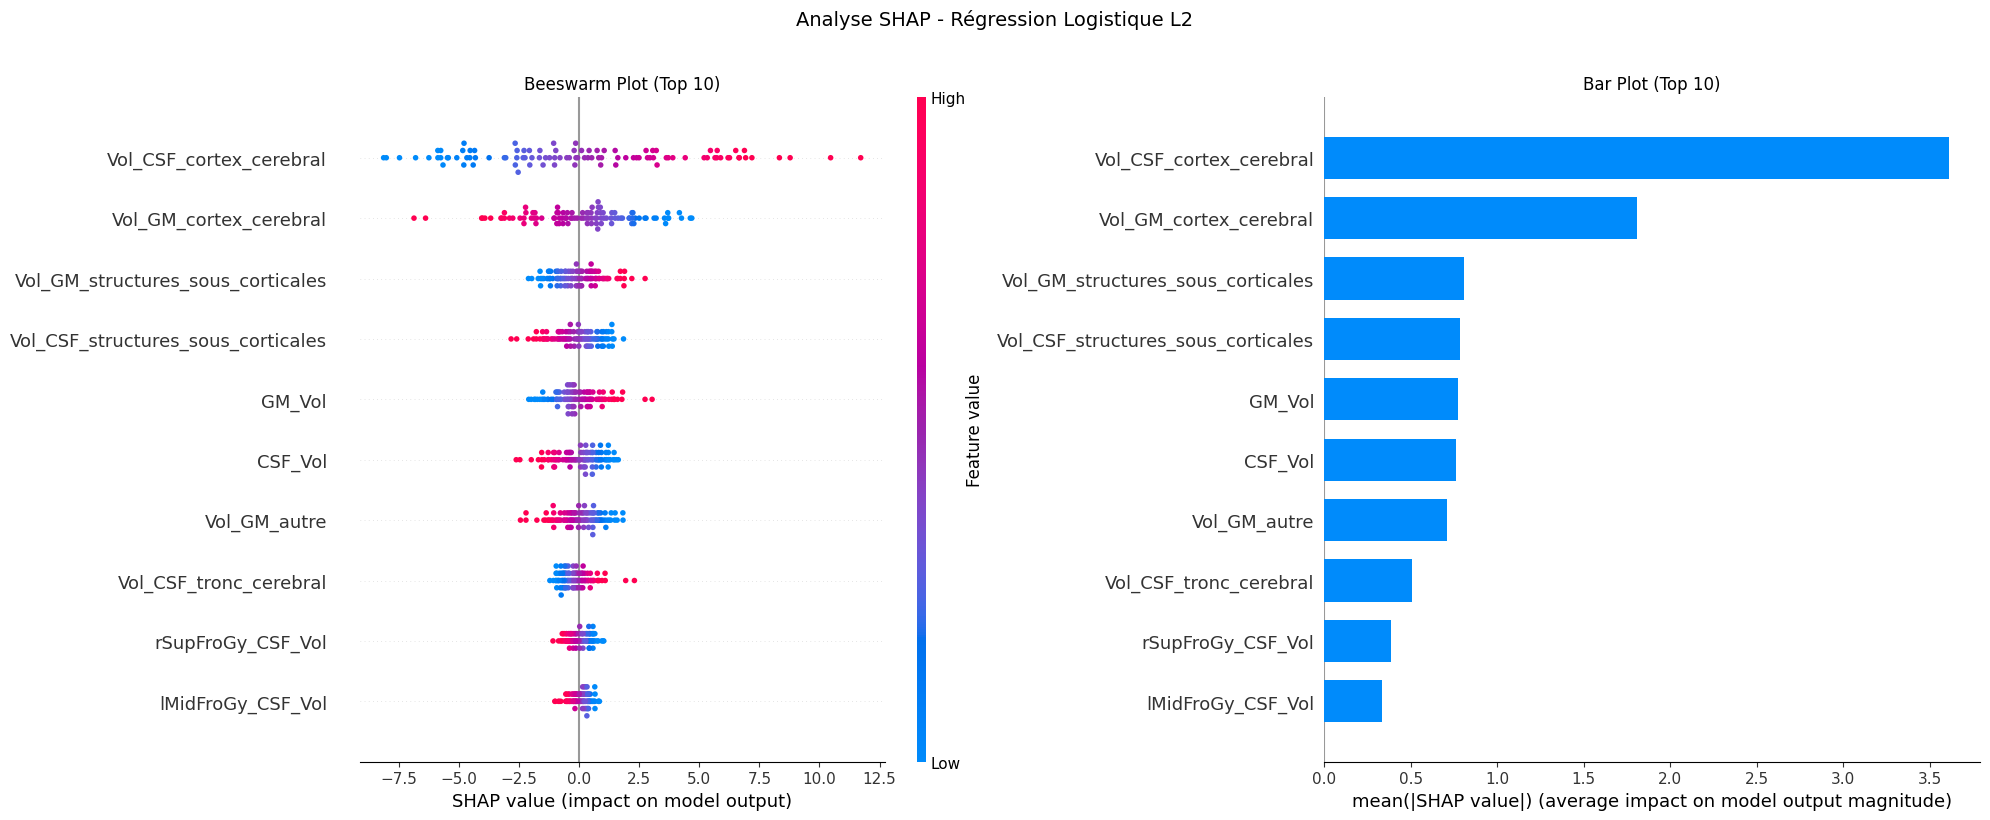


Top 20 variables importantes pour Régression Logistique L2:
[Vol_CSF_cortex_cerebral, Vol_GM_cortex_cerebral, Vol_GM_structures_sous_corticales, Vol_CSF_structures_sous_corticales, GM_Vol, CSF_Vol, Vol_GM_autre, Vol_CSF_tronc_cerebral, rSupFroGy_CSF_Vol, lMidFroGy_CSF_Vol, WM_Vol, lLatVen_CSF_Vol, rExtCbe_CSF_Vol, rSupParLo_CSF_Vol, lMidFroGy_GM_Vol, lSupFroGy_GM_Vol, rAngGy_GM_Vol, rExtCbe_GM_Vol, rInfTemGy_GM_Vol, rThaPro_GM_Vol]


/Users/mahres/Desktop/machine_learning_schizophrenia/predict-schizophrenia-from-gray-matter/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


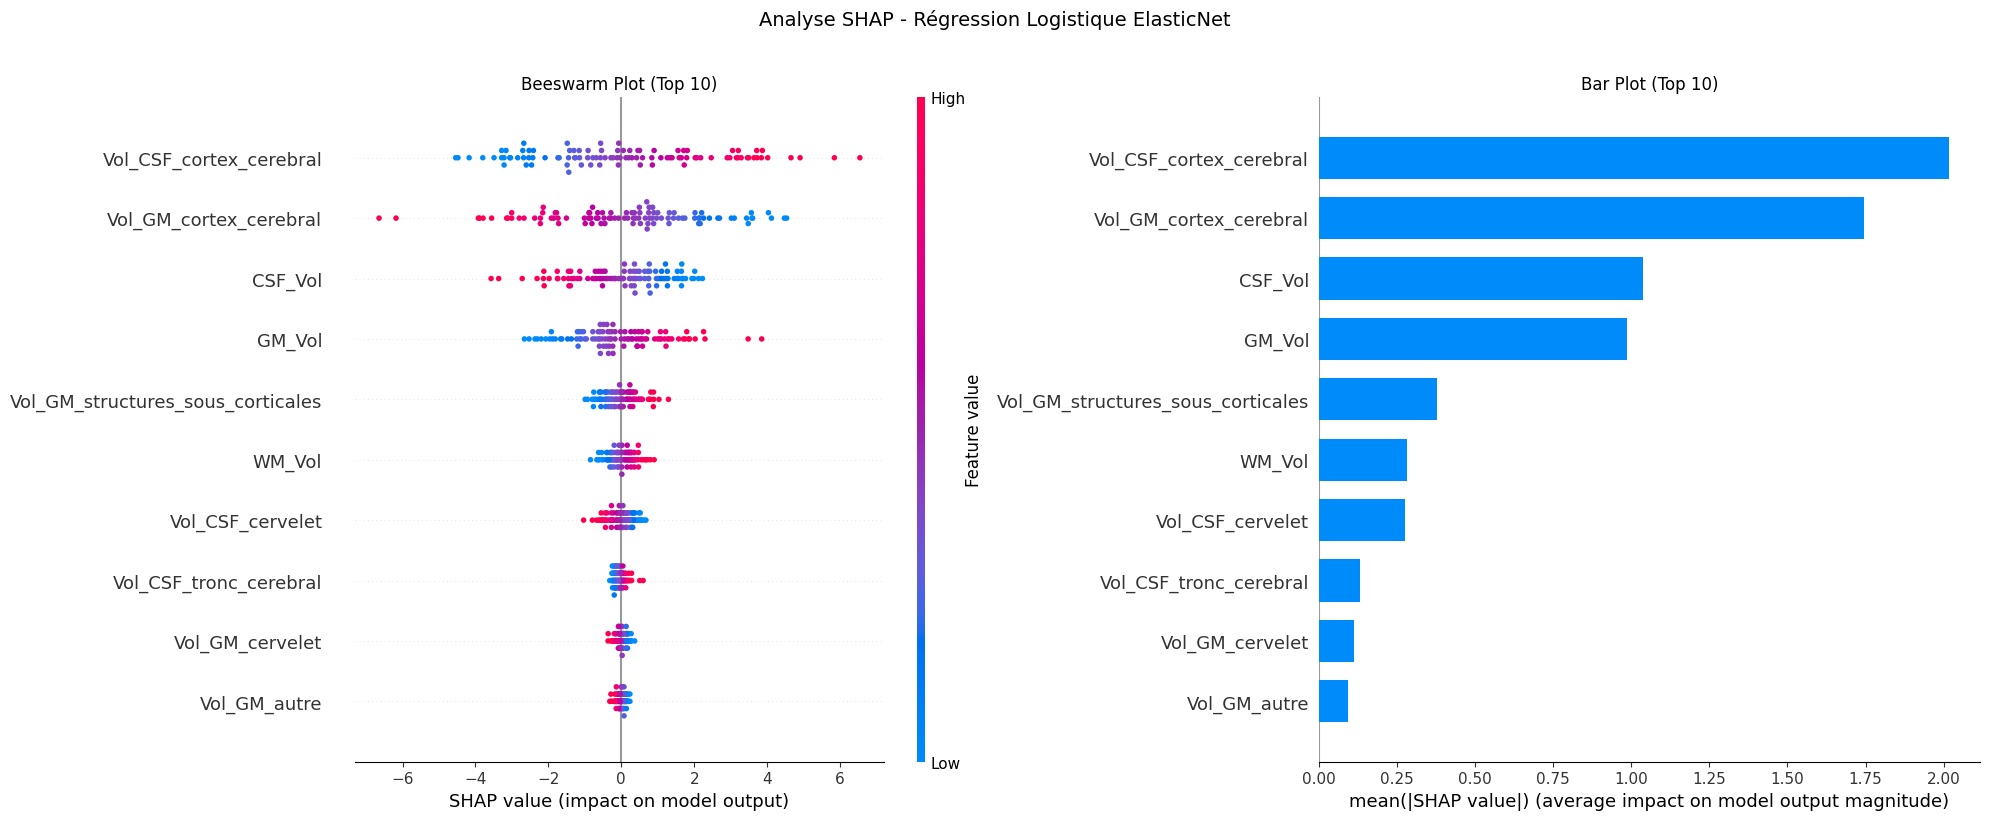


Top 20 variables importantes pour Régression Logistique ElasticNet:
[Vol_CSF_cortex_cerebral, Vol_GM_cortex_cerebral, CSF_Vol, GM_Vol, Vol_GM_structures_sous_corticales, WM_Vol, Vol_CSF_cervelet, Vol_CSF_tronc_cerebral, Vol_GM_cervelet, Vol_GM_autre, rSupParLo_CSF_Vol, rSupFroGy_CSF_Vol, lSupFroGy_CSF_Vol, lSupParLo_CSF_Vol, Vol_CSF_structures_sous_corticales, rExtCbe_CSF_Vol, lPoCGy_CSF_Vol, rPoCGy_CSF_Vol, lExtCbe_CSF_Vol, lPrcGy_CSF_Vol]


In [16]:
def create_shap_analysis(model, X_train, X_test, model_name):
    feature_names = X_test.columns.tolist()
    explainer_shap = shap.Explainer(model, X_train, model_output='probability')
    shap_values = explainer_shap(X_test[:100])
    shap_values_class1 = shap_values.values

    # Calculer les importances pour sélectionner les 10 plus importantes
    feature_importance = np.abs(shap_values_class1).mean(0)
    top_10_indices = np.argsort(feature_importance)[::-1][:10]
    top_10_features = [feature_names[i] for i in top_10_indices]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    plt.suptitle(f"Analyse SHAP - {model_name}", fontsize=14, y=1.02)
    
    # Beeswarm Plot limité aux 10 premières variables
    plt.sca(ax1)
    shap.summary_plot(
        shap_values_class1[:, top_10_indices],
        X_test.iloc[:100, top_10_indices],
        feature_names=top_10_features,
        show=False,
        plot_size=None
    )
    ax1.set_title("Beeswarm Plot (Top 10)")

    # Bar Plot limité aux 10 premières variables
    plt.sca(ax2)
    shap.summary_plot(
        shap_values_class1[:, top_10_indices],
        X_test.iloc[:100, top_10_indices],
        feature_names=top_10_features,
        plot_type="bar",
        show=False,
        plot_size=None
    )
    ax2.set_title("Bar Plot (Top 10)")
    
    plt.tight_layout()
    plt.show()

    # Retourner les 20 premières variables (facultatif si besoin plus tard)
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    return importance_df['feature'].head(20).tolist()


def print_top_features(model_name, top_features):
    """
    Affiche les 20 variables importantes sous forme de liste.
    """
    print(f"\nTop 20 variables importantes pour {model_name}:")
    print(f"[{', '.join(top_features)}]")


models_params = {
    'L1': {
        'params': {
            'penalty': 'l1',
            'solver': 'liblinear',
            'C': 0.09950992842644213,
            'max_iter': 2524,
            'random_state': 42
        },
        'name': 'Régression Logistique L1'
    },
    'L2': {
        'params': {
            'penalty': 'l2',
            'solver': 'lbfgs',
            'C': 0.09835741476856286,
            'max_iter': 1642,
            'random_state': 42
        },
        'name': 'Régression Logistique L2'
    },
    'ElasticNet': {
        'params': {
            'penalty': 'elasticnet',
            'solver': 'saga',
            'C': 0.09360659956296145,
            'max_iter': 2533,
            'l1_ratio': 0.44939891537109655,
            'random_state': 42
        },
        'name': 'Régression Logistique ElasticNet'
    }
}


features_list = test_rois.columns
top_features_by_model = {}

for model_key, model_config in models_params.items():
    model = LogisticRegression(**model_config['params'])
    model.fit(train_rois[features_list], y_train)
    
    top_features = create_shap_analysis(
        model, 
        train_rois[features_list], 
        test_rois[features_list],
        model_config['name']
    )
    top_features_by_model[model_key] = top_features
    
    print_top_features(model_config['name'], top_features)


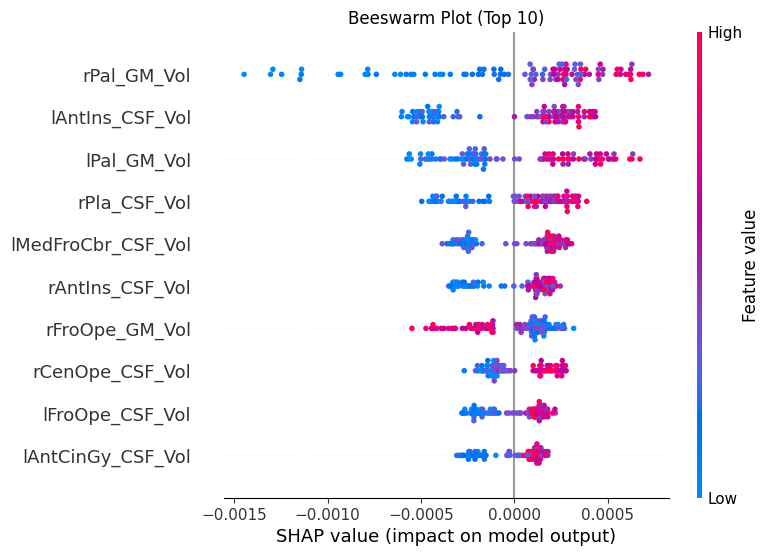

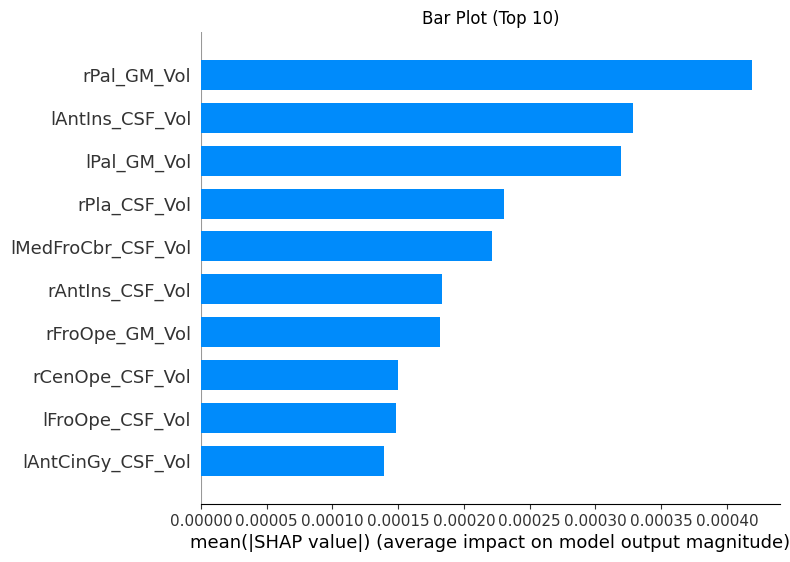


Top 20 variables importantes :
['rPal_GM_Vol', 'lAntIns_CSF_Vol', 'lPal_GM_Vol', 'rPla_CSF_Vol', 'lMedFroCbr_CSF_Vol', 'rAntIns_CSF_Vol', 'rFroOpe_GM_Vol', 'rCenOpe_CSF_Vol', 'lFroOpe_CSF_Vol', 'lAntCinGy_CSF_Vol', 'rInfLatVen_CSF_Vol', 'lHip_GM_Vol', 'rSupMedFroGy_GM_Vol', 'lPla_CSF_Vol', 'rInfFroAngGy_GM_Vol', 'lCenOpe_GM_Vol', 'rInfFroGy_GM_Vol', 'rSupTemGy_GM_Vol', 'lInfFroOrbGy_CSF_Vol', 'rMedFroCbr_CSF_Vol']


In [14]:
def create_shap_plots(model, X_test):
    feature_names = X_test.columns.tolist()

    # Créer l'explainer et calculer les valeurs SHAP
    explainer_shap = shap.TreeExplainer(model)
    shap_values = explainer_shap.shap_values(X_test[:100])

    # Vérifier si shap_values est une liste (cas multi-classes)
    if isinstance(shap_values, list):
        shap_values_class1 = shap_values[1]
    else:
        shap_values_class1 = shap_values

    # Calculer les importances et sélectionner les 10 plus importantes
    mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)
    top_10_indices = np.argsort(mean_abs_shap)[::-1][:10]
    top_10_features = [feature_names[i] for i in top_10_indices]

    # Beeswarm Plot limité aux 10 premières variables
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values_class1[:, top_10_indices],
        X_test.iloc[:100, top_10_indices],
        feature_names=top_10_features,
        show=False
    )
    plt.title("Beeswarm Plot (Top 10)")
    plt.show()

    # Bar Plot limité aux 10 premières variables
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values_class1[:, top_10_indices],
        X_test.iloc[:100, top_10_indices],
        feature_names=top_10_features,
        plot_type="bar",
        show=False
    )
    plt.title("Bar Plot (Top 10)")
    plt.show()

    # Créer un DataFrame pour les 20 premières variables importantes
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Mean_ABS_SHAP": mean_abs_shap
    }).sort_values(by="Mean_ABS_SHAP", ascending=False).head(20)

    return importance_df["Feature"].tolist()


params_gbc = {
    'n_estimators': 56, 
    'learning_rate': 4.450851078458098e-05, 
    'max_depth': 4, 
    'subsample': 0.6922360672727326, 
    'min_samples_split': 15, 
    'min_samples_leaf': 8, 
    'max_features': 0.4093597867018952, 
    'random_state': 42
}

model = GradientBoostingClassifier(**params_gbc)
model.fit(train_rois[features_list], y_train)

important_features = create_shap_plots(model, test_rois[features_list])

print("\nTop 20 variables importantes :")
print(important_features)


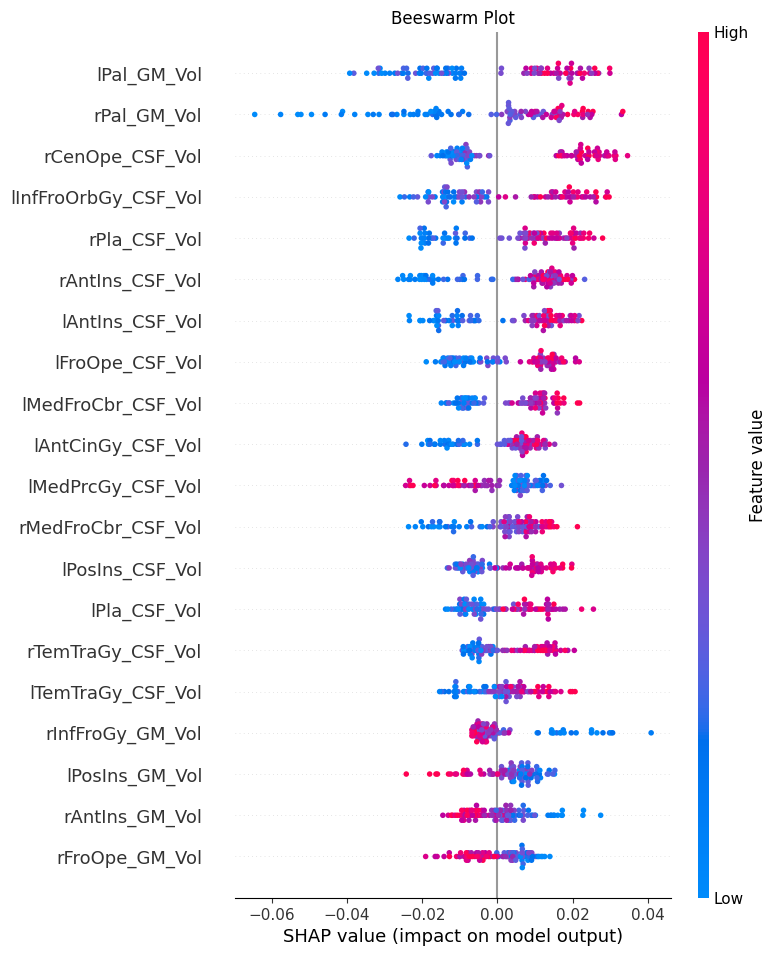

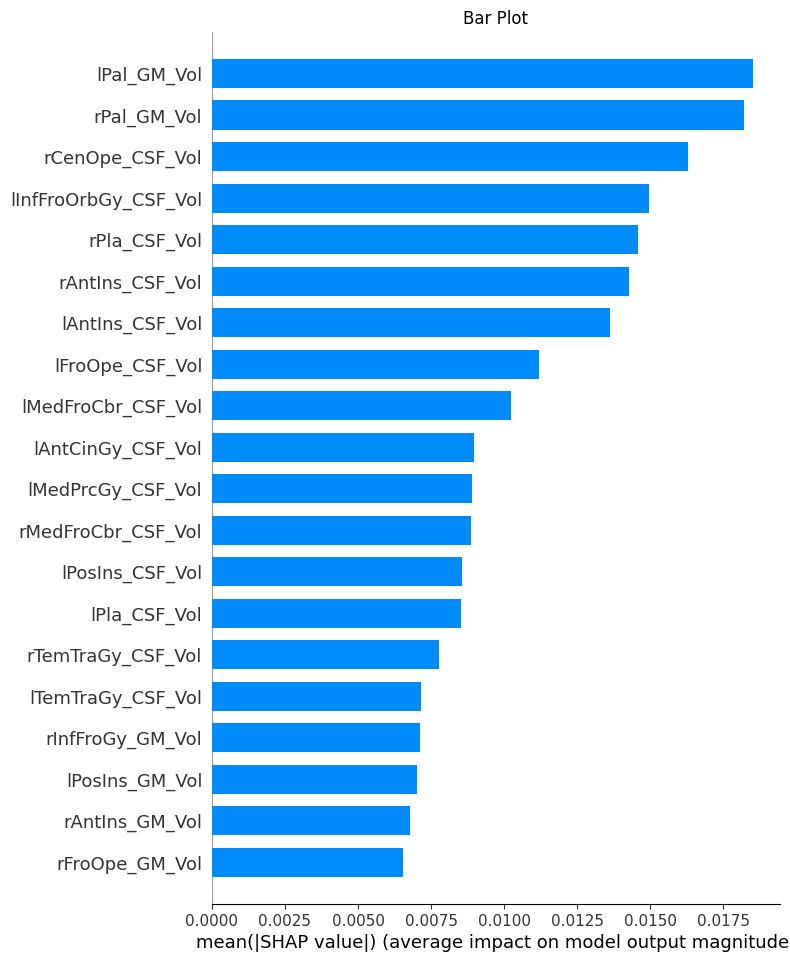

In [17]:
def create_shap_plots(model, X_train, X_test):
    feature_names = X_test.columns.tolist()

    explainer_shap = shap.TreeExplainer(model, X_train, model_output='probability')
    shap_values = explainer_shap(X_test[:100])
    
    shap_values_class1 = shap_values[:, :, 1]

    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values_class1,
        X_test[:100],
        feature_names=feature_names,
        show=False
    )
    plt.title("Beeswarm Plot")
    plt.show()

    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values_class1,
        X_test[:100],
        feature_names=feature_names,
        plot_type="bar",
        show=False
    )
    plt.title("Bar Plot")
    plt.show()

params_rf = {
    'n_estimators': 77,
    'max_depth': 17,
    'min_samples_split': 9,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'bootstrap': False,
    'random_state': 42
}


model = RandomForestClassifier(**params_rf)
model.fit(train_rois[features_list], y_train)

create_shap_plots(model, train_rois[features_list], test_rois[features_list])
